<a href="https://colab.research.google.com/github/r-siddiqi/Hofstadter/blob/main/Integrated_Triangular_Lattice_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from math import gcd

In [ ]:
class Triangular_Hamiltonian:
    """ Triangular lattice simulation with Anderson localization and magnetic field """

    def __init__(self, length: int, t: float, W: float, phi: float, q: int):
        """
          Initialize Triangular_Hamiltonian class.

          Parameters:
              length (int): Lattice size (L x L).
              t (float): Hopping parameter.
              W (float): Disorder parameter.
              phi (float): Magnetic flux per plaquette (in units of flux quantum).
              q (int): Maximum denominator for phi values in Hofstadter butterfly.
        """

        self.L = length
        self.N = self.L * self.L  # Total number of sites
        self.t = t  # Hopping parameter
        self.disorder = W  # Disorder strength
        self.phi = phi  # Magnetic flux per plaquette
        self.max_q = q  # Maximum denominator for phi values
        self.matrix = np.zeros((self.N, self.N), dtype=complex)
        self.on_site_potential = np.zeros(self.N)

    """ Defining and diagonalizing the Hamiltonian for the system """

    def disorder_setter(self):
        # Incorporate the disorder parameter into matrix elements as an on-site disorder potential
        self.on_site_potential = self.disorder * (2 * np.random.rand(self.N) - 1)

    def peierls_phase(self, i, j, delta_i, delta_j):
        """Calculate Peierls phase factor for hopping between sites.

        Parameters:
        ----------
        i : int
            x-index of starting site
        j : int
            y-index of starting site
        delta_i : int
            Change in x-coordinate between sites.
        delta_j : int
            Change in y-coordinate between sites.

        Returns:
        -------
        complex
            Phase factor for the hopping term
        """

        # Using the Landau gauge
        # Average x position during hop
        i_avg = i + delta_i / 2

        # Phase accumulated during hop
        phase = np.exp(2j * np.pi * self.phi * i_avg * delta_j)

        return phase

    def construct_hamiltonian(self):
        """Construct the Hamiltonian matrix with hopping and disorder terms."""
        self.disorder_setter()
        self.matrix = np.zeros((self.N, self.N), dtype=complex)

        for i in range(self.L):
            for j in range(self.L):
                n = i * self.L + j

                # On-site potential
                self.matrix[n, n] = self.on_site_potential[n]

                # List of the six nearest neighbors
                neighbors = [
                    (1, 0),    # Right (+i)
                    (0, 1),    # Up (+j)
                    (-1, 1),   # Up-Left (-i, +j)
                    (-1, 0),   # Left (-i)
                    (0, -1),   # Down (-j)
                    (1, -1)    # Down-Right (+i, -j)
                ]

                for delta_i, delta_j in neighbors:
                    i_neighbor = (i + delta_i) % self.L
                    j_neighbor = (j + delta_j) % self.L
                    n_neighbor = i_neighbor * self.L + j_neighbor

                    # Calculate Peierls phase
                    phase = self.peierls_phase(i, j, delta_i, delta_j)

                    # Add hopping term
                    self.matrix[n, n_neighbor] += -self.t * phase

        # Ensure Hamiltonian is Hermitian
        self.H = (self.matrix + self.matrix.conj().T) / 2

        # Compute eigenvalues and eigenvectors
        self.evals, self.evecs = np.linalg.eigh(self.H)

    """ Basic plotting functions """

    def plot_evals(self):
         # Plot eigenvalues of hamiltonian matrix
        legend = f'L={self.L}, t={self.t}, W={self.disorder}, $\\phi$={self.phi}'
        plt.figure(figsize=(8, 6))
        plt.plot(self.evals, '.', markersize=5)
        plt.ylabel(r'Eigenvalues $E_i$')
        plt.xlabel('Index $i$')
        plt.title('Eigenvalue Spectrum of the Honeycomb Lattice')
        plt.legend([legend])
        plt.grid(True)
        plt.show()

    def plot_evec(self):
        # Plot some eigenvector in the middle of the spectrum
        self.psi = self.evecs[:, self.L // 2]

        legend = f'L={self.L}, t={self.t}, W={self.disorder}, $\\phi$={self.phi}'
        plt.figure(figsize=(8, 6))
        plt.plot(np.abs(self.psi) ** 2)
        plt.xlabel('Site Index')
        plt.ylabel(r'$|\psi(x)|^2$')
        plt.title('Arbitrary Eigenvector')
        plt.legend([legend])
        plt.grid(True)
        plt.show()

    def plot_evec_disorder(self):
        # Plot an eigenvector in the presence of disorder
        self.psi = self.evecs[:, self.L // 2]  # Eigenvector in the middle of the spectrum

        fig, ax = plt.subplots(2, 1, sharex=True)
        ax[0].plot(np.abs(self.psi) ** 2)
        ax[1].semilogy(np.abs(self.psi) ** 2)
        ax[1].set_xlabel('Site Index')
        ax[0].set_ylabel(r'$|\psi(x)|^2$')
        ax[1].set_ylabel(r'$|\psi(x)|^2$')

        legend = f'L={self.L}, t={self.t}, W={self.disorder}, $\\phi$={self.phi}'
        ax[0].set_title('Arbitrary Eigenvector')
        ax[0].legend([legend])
        ax[0].grid(True)
        ax[1].grid(True)
        plt.show()

    def plot_pr(self):
        # Plot Inverse Participation Ratio
        self.PR = 1. / np.sum(np.abs(self.evecs) ** 4, axis=0)  # Sum over spatial coordinates

        legend = f'L={self.L}, t={self.t}, W={self.disorder}, $\\phi$={self.phi}'
        plt.figure(figsize=(8, 6))
        plt.plot(self.evals, self.PR, 'o')
        plt.xlabel('Energy $E$')
        plt.ylabel('Inverse Participation Ratio (IPR)')
        plt.title('Localization Properties')
        plt.legend([legend])
        plt.grid(True)
        plt.show()

    """ Advanced computations and plotting """

    def plot_hofstadter_butterfly(self):
        # Plot the Hofstadter butterfly
        plt.figure(figsize=(10, 8))
        phis = []
        energies = []

        for q in range(1, self.max_q + 1):
            for p in range(q+1):
                if gcd(p, q) == 1:
                    self.phi = p / q
                    self.construct_hamiltonian() # Reconstruct hamiltonian for each allowed phi
                    phis.extend([self.phi] * self.N)
                    energies.extend(self.evals.tolist())


        plt.scatter(phis, energies, s=0.1, color='black')
        plt.xlabel('Flux per Plaquette $\\phi$')
        plt.ylabel('Energy $E$')
        plt.title(f'Hofstadter Butterfly for $\\phi = p / {self.max_q}$ and $W = {self.disorder}$')
        plt.grid(True)
        plt.show()

    def plot_density_of_states(self, sigma=0.1, num_points=1000):
        """
        Plot the density of states using Gaussian broadening.

        Parameters:
            sigma (float): Standard deviation for Gaussian broadening.
            num_points (int): Number of points in the energy grid.
        """
        energy_min = np.min(self.evals) - 1
        energy_max = np.max(self.evals) + 1
        E_vals = np.linspace(energy_min, energy_max, num_points)  # Energy grid
        dos = np.zeros_like(E_vals)

        for E_n in self.evals:
            dos += np.exp(-((E_vals - E_n) ** 2) / (2 * sigma ** 2)) / (np.sqrt(2 * np.pi) * sigma)  # Gaussian broadening

        legend = f'L={self.L}, t={self.t}, W={self.disorder}, $\\phi$={self.phi}'
        plt.figure(figsize=(8, 6))
        plt.plot(E_vals, dos)
        plt.xlabel('Energy $E$')
        plt.ylabel('Density of States $g(E)$')
        plt.title('Density of States for Honeycomb Lattice')
        plt.legend([legend])
        plt.grid(True)
        plt.show()


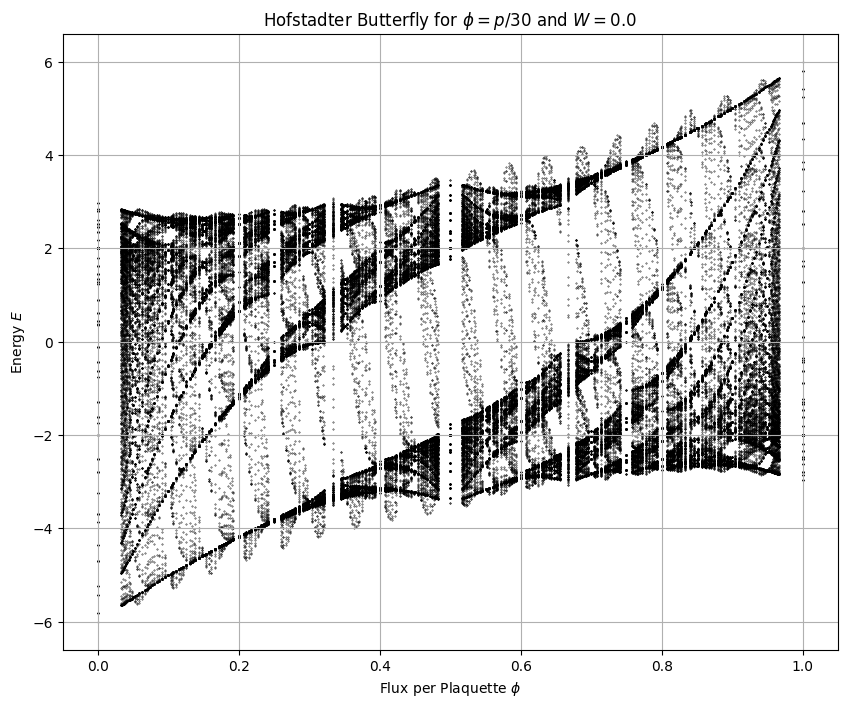

In [14]:
# Hofstadter butterfly with no disorder
model = Triangular_Hamiltonian(length=20, t=1.0, W=0.0, phi=0.0, q=30)
model.construct_hamiltonian()
model.plot_hofstadter_butterfly()